<a href="https://colab.research.google.com/github/calebarr/AIS/blob/ais_cleaning/Copy_of_AIS_Downloader_TeamShared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AIS Data Downloader - Google Colab Version (Team-Ready)

# Mount Google Drive
from google.colab import drive
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import zipfile

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define the AIS downloader function
def download_ais_data(start_date_str, end_date_str, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    print(f"Files will be saved to: {save_folder}")

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")


    # Download each file in the date range
    for i in range((end_date - start_date).days + 1):
        date_obj = start_date + timedelta(days=i)
        filename = f"AIS_{date_obj.strftime('%Y_%m_%d')}.zip"
        url = f"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2020/{filename}"
        file_path = os.path.join(save_folder, filename)

        if not os.path.exists(file_path):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
                print(f"Saved: {file_path}")
            else:
                print(f"Failed: {response.status_code}")
        else:
            print(f"Already downloaded: {filename}")

# Now call the function with your chosen parameters
download_ais_data(
    start_date_str="2020-03-10",
    end_date_str="2020-04-16",
    save_folder="/content/drive/My Drive/SIADS_593/assets/raw_data"
)


Mounting Google Drive...
Mounted at /content/drive
Files will be saved to: /content/drive/My Drive/SIADS_593/assets/raw_data
Already downloaded: AIS_2020_03_10.zip
Already downloaded: AIS_2020_03_11.zip
Already downloaded: AIS_2020_03_12.zip
Already downloaded: AIS_2020_03_13.zip
Already downloaded: AIS_2020_03_14.zip
Already downloaded: AIS_2020_03_15.zip
Already downloaded: AIS_2020_03_16.zip
Already downloaded: AIS_2020_03_17.zip
Already downloaded: AIS_2020_03_18.zip
Already downloaded: AIS_2020_03_19.zip
Already downloaded: AIS_2020_03_20.zip
Already downloaded: AIS_2020_03_21.zip
Already downloaded: AIS_2020_03_22.zip
Already downloaded: AIS_2020_03_23.zip
Already downloaded: AIS_2020_03_24.zip
Already downloaded: AIS_2020_03_25.zip
Already downloaded: AIS_2020_03_26.zip
Already downloaded: AIS_2020_03_27.zip
Already downloaded: AIS_2020_03_28.zip
Already downloaded: AIS_2020_03_29.zip
Already downloaded: AIS_2020_03_30.zip
Already downloaded: AIS_2020_03_31.zip
Already downloade

In [ ]:
#!ls -lh "/content/drive/My Drive/SIADS_593/assets/raw_data"


In [ ]:
def process_zip_in_chunks(zip_path, chunksize=100_000):

    all_cleaned_chunks = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        if not csv_files:
            return pd.DataFrame()

        with zip_ref.open(csv_files[0]) as f:
            reader = pd.read_csv(f, chunksize=chunksize)
            for chunk in reader:
                cleaned = extract_first_arrivals_anywhere(chunk)
                all_cleaned_chunks.append(cleaned)

    return pd.concat(all_cleaned_chunks, ignore_index=True)


In [ ]:
def extract_first_arrivals_anywhere(df):
    # Filter by relevant vessel types
    df = df[
        df["VesselType"].isin(range(70, 90)) | df["VesselType"].isin([30, 52])
    ].copy()

    # Drop rows with missing or invalid coordinates
    df = df.dropna(subset=["LAT", "LON"])
    df = df[(df["LAT"] != 0) & (df["LON"] != 0)]

    # Convert timestamps
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce')

    df = df.dropna(subset=["BaseDateTime"])

    # Filter for ships that are of Status 1 & 5 (Anchored)
    if "Status" in df.columns:
      df = df[df["Status"].isin([1, 5])]

    """
    Working on cleaning this section
    """
    # Drop all the columns that are not need
    columns_to_drop = ["SOG", "COG", "Heading", "IMO", "VesselName", "Length", "Width", "TransceiverClass", "Cargo", "CallSign", "Draft"]
    existing_cols = [col for col in columns_to_drop if col in df.columns]

    df = df.drop(columns=existing_cols)

    # End of cleaning

    # Sort and get the first ping per MMSI
    first_arrivals = (
        df.sort_values(["MMSI", "BaseDateTime"])
          .drop_duplicates("MMSI", keep="first")
    )

    # Assign port names
    return assign_port_names(first_arrivals)


In [ ]:
def assign_port_names(df, buffer=1.3):
    PORT_REGIONS = {
        "Los Angeles": (33.6, 33.9, -118.5, -118.0),
        "Long Beach": (33.7, 33.9, -118.25, -118.15),
        "Oakland": (37.7, 37.85, -122.35, -122.2),
        "Seattle": (47.5, 47.7, -122.4, -122.2),
        "New York": (40.6, 40.8, -74.1, -73.9),
        "Norfolk": (36.8, 37.1, -76.4, -76.2),
        "Savannah": (32.0, 32.2, -81.2, -80.8),
        "Charleston": (32.7, 32.9, -80.0, -79.8),
        "Miami": (25.75, 25.85, -80.2, -80.0),
        "Port Everglades": (26.05, 26.1, -80.15, -80.1),
        "Baltimore": (39.2, 39.3, -76.6, -76.5),
        "Philadelphia": (39.9, 40.0, -75.2, -75.1),
        "Houston": (29.6, 29.8, -95.2, -94.8),
        "New Orleans": (29.9, 30.1, -90.1, -89.9),
        "Jacksonville": (30.3, 30.5, -81.7, -81.3),
        "San Diego": (32.7, 32.8, -117.2, -117.1),
        "Boston": (42.3, 42.4, -71.1, -70.9),
        "Anchorage": (61.1, 61.3, -149.95, -149.8),
        "Honolulu": (21.3, 21.4, -157.9, -157.8),
        "Portland": (45.6, 45.7, -122.7, -122.6),
        "Puerto Rico": (18.2, 18.3, -66.3, -66.2),
        "Tacoma": (47.2, 47.4, -122.55, -122.35),
        "Port Arthur": (29.85, 29.95, -93.95, -93.85),
        "Beaumont": (30.0, 30.1, -94.15, -94.05),
        "Corpus Christi": (27.75, 27.9, -97.45, -97.25),
        "Baton Rouge": (30.4, 30.5, -91.25, -91.15),
        "Mobile": (30.6, 30.7, -88.1, -88.0),
        "Tampa": (27.9, 28.0, -82.5, -82.4),
        "San Francisco": (37.75, 37.85, -122.45, -122.3),
        "Wilmington (DE)": (39.7, 39.75, -75.55, -75.5),
        "Camden (NJ)": (39.9, 39.95, -75.1, -75.05),
        "Providence": (41.7, 41.8, -71.45, -71.35),
        "Unknown": (None, None, None, None),  # fallback
    }

    def get_port_name(lat, lon):
        for port, bounds in PORT_REGIONS.items():
            if None in bounds:
                continue  # skip 'Unknown'
            min_lat, max_lat, min_lon, max_lon = bounds
            if (min_lat - buffer) <= lat <= (max_lat + buffer) and \
               (min_lon - buffer) <= lon <= (max_lon + buffer):
                return port
        return "Unknown"

    df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)
    return df



In [ ]:
def concat_all_zips_from_folder(folder_path):
    zip_files = sorted([
        os.path.join(folder_path, fname)
        for fname in os.listdir(folder_path)
        if fname.endswith(".zip")
    ])

    all_dataframes = []
    for zip_path in zip_files:
        print(f"Processing: {zip_path}")
        df = process_zip_in_chunks(zip_path)
        all_dataframes.append(df)

    combined_df = pd.concat(all_dataframes, ignore_index=True)
    return combined_df


In [ ]:
raw_data_dir = "/content/drive/My Drive/SIADS_593/assets/raw_data"
vessel_data = concat_all_zips_from_folder(raw_data_dir)


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_10.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_11.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_12.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_13.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_14.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_15.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_16.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_17.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_18.zip


<ipython-input-8-fe2e1f857b8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_19.zip


<ipython-input-8-fe2e1f857b8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_20.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_21.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_22.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_23.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_24.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_25.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_26.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_27.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_28.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_29.zip


<ipython-input-8-fe2e1f857b8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_30.zip


<ipython-input-8-fe2e1f857b8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_03_31.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_01.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_02.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_03.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_04.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_05.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_06.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_07.zip


<ipython-input-7-ce20ab5aa661>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce')


Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_08.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_09.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_10.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_11.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_12.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_13.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_14.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_15.zip
Processing: /content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_04_16.zip


In [ ]:
def clean_and_save_first_arrivals(vessel_data, output_csv_path):
    # Drop rows where 'Port Name' is 'Unknown'
    cleaned_df = vessel_data[vessel_data['Port Name'] != 'Unknown'].copy()

    # Create the output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

    # Save the cleaned DataFrame to a CSV file
    cleaned_df.to_csv(output_csv_path, index=False)

    print(f"Cleaned data saved to: {output_csv_path}")
    print("Shape of the cleaned data:", cleaned_df.shape)

    return cleaned_df


End of script everything else is extra

In [ ]:
cleaned_csv_path = "/content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv"
cleaned_df = clean_and_save_first_arrivals(vessel_data, cleaned_csv_path)


Cleaned data saved to: /content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv
Shape of the cleaned data: (1653365, 7)


This the end of the script everything else is Extra

In [ ]:
first_arrivals_df = extract_first_arrivals_anywhere(vessel_data)
first_arrivals_df["Port Name"].value_counts()



,count
Port Name,
Unknown,910
Houston,531
New Orleans,302
Los Angeles,284
New York,241
Miami,146
Savannah,121
Seattle,119
Portland,99


In [ ]:
print(vessel_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995497 entries, 0 to 1995496
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   MMSI          int64         
 1   BaseDateTime  datetime64[ns]
 2   LAT           float64       
 3   LON           float64       
 4   VesselType    float64       
 5   Status        float64       
 6   Port Name     object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 106.6+ MB
None


In [ ]:
anchored_ships = vessel_data[vessel_data["Status"] == 5]
anchored_ships = vessel_data[vessel_data["Status"] == 1]
df =anchored_ships
df.head(10)


,MMSI,BaseDateTime,LAT,LON,VesselType,Status,Port Name
1,205543000,2020-03-10 00:01:30,29.33625,-94.58277,80.0,1.0,Houston
2,209148000,2020-03-10 00:01:00,34.60947,-76.63238,70.0,1.0,Unknown
6,210059000,2020-03-10 00:00:38,27.62148,-83.01884,70.0,1.0,Tampa
8,210234000,2020-03-10 00:01:35,29.60503,-89.85290,70.0,1.0,New Orleans
9,210263000,2020-03-10 00:00:33,48.79803,-123.23741,70.0,1.0,Seattle
12,212522000,2020-03-10 00:01:32,29.63888,-93.29527,80.0,1.0,Port Arthur
15,212871000,2020-03-10 00:00:05,37.75103,-122.34348,80.0,1.0,Oakland
17,215322000,2020-03-10 00:01:06,30.04680,-90.54819,89.0,1.0,New Orleans
31,228333700,2020-03-10 00:00:17,36.85513,-75.64044,80.0,1.0,Norfolk
33,229079000,2020-03-10 00:03:02,29.30532,-94.50440,80.0,1.0,Houston


In [ ]:
print(f"Number of anchored ships: {len(anchored_ships)}")


Number of anchored ships: 823019


In [ ]:
anchored_by_port = anchored_ships["Port Name"].value_counts()
print(anchored_by_port)


Port Name
Houston            261495
Unknown            140340
New Orleans        132201
Los Angeles         42671
Corpus Christi      39365
Seattle             31891
Oakland             26056
New York            25269
Portland            22062
Mobile              16326
Miami               13325
Port Arthur         12983
Savannah            12399
Norfolk             10213
Baltimore            9128
Puerto Rico          5826
Boston               5022
Tampa                4443
Philadelphia         4312
Wilmington (DE)      2509
Honolulu             1920
San Diego            1649
Jacksonville         1140
Charleston            409
Providence             59
Tacoma                  6
Name: count, dtype: int64


In [ ]:
#Start Check for duplicates

In [ ]:
# Checking for duplicate MMSi S (unique ship IDuigd)
first_arrivals = extract_first_arrivals_anywhere(vessel_data)

# Check for duplicates in MMSI
duplicates = first_arrivals[first_arrivals.duplicated("MMSI", keep=False)]

print(f"Number of duplicate MMSI entries: {len(duplicates)}")
if not duplicates.empty:
    print(duplicates)


Number of duplicate MMSI entries: 0


In [ ]:
# Check for full row duplicates
full_dupes = first_arrivals[first_arrivals.duplicated(keep=False)]
print(f"Duplicate full rows: {len(full_dupes)}")

# Optional: check that each MMSI is only listed once
assert first_arrivals["MMSI"].is_unique, "⚠️ Duplicate MMSIs found!"


Duplicate full rows: 0


In [ ]:
mmsi_counts = first_arrivals["MMSI"].value_counts()
print(mmsi_counts.head())

# Show MMSIs that appear more than once
print("MMSIs with multiple entries:")
print(mmsi_counts[mmsi_counts > 1])


MMSI
710023040    1
677062300    1
677031100    1
671960000    1
671947000    1
Name: count, dtype: int64
MMSIs with multiple entries:
Series([], Name: count, dtype: int64)


In [ ]:
#End of Check for Duplicates

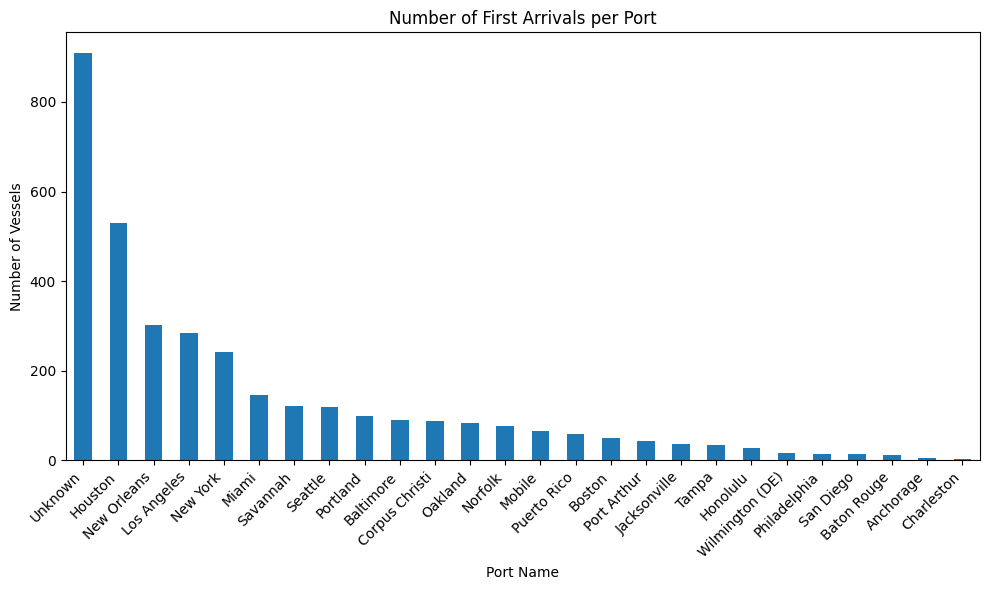

In [ ]:
# prompt: create bar chart

import matplotlib.pyplot as plt

# Assuming 'first_arrivals_df' is already created and contains the 'Port Name' column
if 'Port Name' in first_arrivals_df.columns:
    port_counts = first_arrivals_df["Port Name"].value_counts()

    plt.figure(figsize=(10, 6))
    port_counts.plot(kind='bar')
    plt.title('Number of First Arrivals per Port')
    plt.xlabel('Port Name')
    plt.ylabel('Number of Vessels')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("The DataFrame does not contain a 'Port Name' column to create the bar chart.")

In [ ]:
import plotly.express as px

# Sample 500 points to make rendering faster, or skip .sample() to show all
sample_df = first_arrivals_df.sample(n=500, random_state=42)

fig = px.scatter_geo(
    sample_df,
    lat='LAT',
    lon='LON',
    color='Port Name',
    hover_name='VesselType',
    title='First Arrivals: Vessel Locations by Port',
    projection="natural earth"
)

fig.update_layout(geo=dict(
    scope='world',
    showland=True,
    landcolor="lightgray",
))

fig.show()
